In [1]:
from pprint import pprint
import sklearn
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
#import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt

#import pyLDAvis
#from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_score, precision_recall_curve, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
#from sklearn.metrics.pairwise import cosine_similarity
#from sklearn.base import BaseEstimator, TransformerMixin
#from sklearn.pipeline import FeatureUnion
#from sklearn.feature_extraction import DictVectorizer
#from sklearn.metrics import accuracy_score
#from sklearn.model_selection import GridSearchCV
#from sklearn.decomposition import LatentDirichletAllocation

#from imblearn.over_sampling import SMOTE 
from os import path
from wordcloud import WordCloud, STOPWORDS 
#from PIL import Image
from wordcloud import ImageColorGenerator
import re
#import pickle
#import joblib
import spacy

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from nltk import word_tokenize,sent_tokenize
from nltk.stem.porter import PorterStemmer
#from textblob import TextBlob
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import datetime
import warnings

In [6]:
raw_df= pd.read_csv(r'G:/Symbi/Dataset/TelecomPOC New.csv',encoding='utf-8', parse_dates=[1])
#raw_df= pd.read_csv(r'C:/Users/Tanisha Batra/Vi_tweets_test.csv',encoding='utf-8')
raw_df.head()
#neg = raw_df[raw_df.Sentiment1=='Negative']
#neg = neg.reset_index(drop=True)
text = raw_df.Tweet.dropna()
print(text)

#raw_df= raw_df[pd.notnull(raw_df['Tweet'])] #Delete rows where Tweet is null.

0       @Vodafone won't not let me port to @JioCare f...
1            @jiocare Jio internet services depressing. 
2      @jiocare #jiofraud, no action in my complaint,...
3      @jiocare Was recharging for Jio 999 plan. When...
4      @jiocare It's been officially 10 days. Yet, no...
                             ...                        
356         Wants to access News channels through phone.
357    Customer wants to block calls from a particula...
358                                Checking IMEI status.
359    Called to report demise of her grandmother & w...
360                                Checking IMEI status.
Name: Tweet, Length: 361, dtype: object


In [7]:
def clean_tweet(RawSentence):
    """
    removing all hashtags , punctuations, stop_words  and links, also stemming words 
    """
        
    txt = RawSentence.lower()
    word_tokens = word_tokenize(txt)    
    #word_tokens = word_tokenize(RawSentence)    
    
    lemma = WordNetLemmatizer()
    nlp = spacy.load('en_core_web_sm') 

    stop_words = set(stopwords.words('english'))
    stop_words.update(["amp", "rt", "cc"]) # adding twitter specific stop words
    #stop_words = stop_words - set(['no', 'not','nil'])  #removing No, not, nil from stop words     
    stop_words.update(["worst","airtelpresence","sunday","monday","tuesday","wednesday","thursday","friday","saturday",
                       "weekend","apparently","extremely","worse","consolation","shouldnt","wont","arent","maybe"
                     "better", "other","instead","look","yesterday","unacceptable","miss","couldnt","depress","let",
                     "thank","actually","frustrate","ridiculous","expect","pathetic","terrible","hathway",
                     "impossible","ask","earlier","literally","years","surprise","horrible","airtel","current","face",
                     "upset","pls","one","two","three","four","empty","please","good","finally","proper","development",
                     "situation","company","believe","question","anymore","consolation","mess","shock","longer","twitter",
                      "completely","finally", "waste","shock","annoy","strand",
                      "important","break","reason", "first","second","third","attempt","officially","absolutely","hello","yet","know","jio",
                      "january","february","march","april","may","june","july","august","september","october","november","december","without",
                      "vodafone","get","vodafoneidea","vicustomercare","vowifi","since","voda","reliancejio","jiocare","time","number"])
   
    txt = re.sub(r"(@\S+)", "", txt)  # remove @
    txt = re.sub(r'\W', ' ', str(txt)) # remove all special characters including apastrophie 
    txt = txt.translate(str.maketrans(' ', ' ', string.punctuation)) # remove punctuations 
    txt = re.sub(r'\s+[a-zA-Z]\s+', ' ', txt)   # remove all single characters from within the text (it's -> it s then we need to remove s)
    txt = re.sub(r'\^[a-zA-Z]\s+', ' ', txt) # remove all single characters from beginning of the text 
    txt = re.sub(r'\s+', ' ', txt, flags=re.I) # Substituting multiple spaces with single space
    txt = re.sub(r"(http\S+|http)", "", txt) # remove links 
    #txt = re.sub(r'^b\s+', '', txt) # generally used when text is scrapped online. 'b' is prefixed often indicating binary text. This is not reqd for us 
    txt = [re.sub('\s+', ' ', t) for t  in txt]     # Remove new line characters
    txt = ''.join([i for i in txt if not i.isdigit()]).strip() # remove digits ()
    txt = ' '.join([i for i in txt.split(" ") if i not in stop_words])   # split() is native tokenizer in Python
    #txt = ' '.join(lemma.lemmatize(word) for word in txt.split())           # Used lemmatizer later 
    #txt = ' '.join([PorterStemmer().stem(word=word) for word in txt.split(" ") if word not in stop_words ]) # stem & remove stop words
    #soup = BeautifulSoup(txt) #to scrap information from web pages....not needed here
    #txt = soup.get_text
    
    def deEmojify(inputString):
        return inputString.encode('ascii', 'ignore').decode('ascii')
    
    def stem_tokens(tokens, lemmatize):
        lemmatized = []
        for item in tokens:
            lemmatized.append(lemma.lemmatize(item,'v'))
        return lemmatized
    
    txt = deEmojify(txt)
    tokens =[]
    
    excluded_tags = {"ADJ", "ADV", "ADP", "PROPN","CCONJ","AUX","DET","PRON","VERB"}
    for token in nlp(txt):
        if token.pos_ not in excluded_tags:
            tokens.append(token.text)
    
    lemm = stem_tokens(tokens, lemma)
    #tokens = nltk.word_tokenize(txt)
    tokens = [ch for ch in lemm if len(ch)>2] #remove words with character length below 3
    #tokens = [ch for ch in tokens if len(ch)<=15] #remove words with character length above 15 
    
    joined_text = ' '.join(tokens)
        
    return joined_text

In [8]:
raw_df['clean_tweet'] = raw_df.Tweet.apply(clean_tweet)

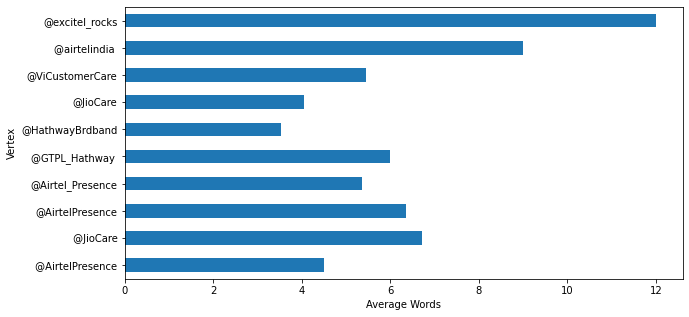

In [14]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
X=raw_df['clean_tweet']
X_train,X_test =train_test_split(X,test_size=0.3)
#print(X_train)
# calculate number of tokens for each tweet
raw_df['tokens'] = raw_df['clean_tweet'].str.split().str.len()# plot average word count by user
raw_df.groupby('Vertex2')['tokens'].mean().plot(kind='barh',figsize=(10,5))
plt.xlabel('Average Words')
plt.ylabel('Vertex')
plt.show()

In [15]:
!git clone https://github.com/rwalk/gsdmm.git gsdmm

Cloning into 'gsdmm'...


In [17]:
!pip install gsdmm
python3 -m pip install google-cloud-dataproc

ERROR: Could not find a version that satisfies the requirement gsdmm (from versions: none)
ERROR: No matching distribution found for gsdmm


In [18]:
import gsdmm
from gsdmm import MovieGroupProcess
from tqdm import tqdm# convert string of tokens into tokens list
raw_df['tokens'] = X.apply(lambda x: re.split('\s', x))# create list of  token lists
docs = raw_df['tokens'].tolist()


ImportError: cannot import name 'MovieGroupProcess' from 'gsdmm' (unknown location)

In [45]:
# vectorize the corpus. the vectorizer object will convert text to vector form on the basis of frequency (count) of each word in text
#Vectorization is a process of converting the text data into a machine-readable form. Each word forms the index. 
#min_df - will ignore words that are present in min_df percent or less no of documents 
#max_df - will take words that are present in max df percent of all the documents

#vectorizer = CountVectorizer(max_df=0.9, min_df=10, ngram_range=(1,2), token_pattern='\w+|\$[\d\.]+|\S+') 
#tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=20, ngram_range=(1,2), token_pattern='\w+|\$[\d\.]+|\S+') 
#vectorizer = CountVectorizer(max_df=.95, min_df=0.05, ngram_range=(1,2),token_pattern='\w+|\$[\d\.]+|\S+')
#vectorizer = CountVectorizer(max_df=0.9, min_df=0.2, ngram_range=(1,2)) 
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=10, ngram_range=(1,2))


In [46]:
#vectors = tfidf_vectorizer.fit_transform(raw_df['clean_tweet']).toarray()
vectors = tfidf_vectorizer.fit_transform(X_train)
vectors.shape
#vectors.nnz /float(vectors.shape[0])
features = tfidf_vectorizer.get_feature_names()
feature_order = np.argsort(tfidf_vectorizer.idf_)[::-1]
top_n = 10
top_n_features = [features[i] for i in feature_order[:top_n]]
print(top_n_features)


['team', 'care', 'india', 'port', 'customers', 'problem', 'response', 'call', 'speed', 'store']


In [47]:
Test_Vectors=tfidf_vectorizer.transform(X_test).toarray()
Test_Vectors.shape

(88, 21)

In [48]:
from sklearn import metrics
clf = MultinomialNB(alpha=.01)
clf.fit(vectors, X_train )
pred = clf.predict(Test_Vectors) 
metrics.f1_score(X_test, pred, average='macro')

0.027741330834114338